## Image classification with Convolutional Neural Networks

## Dog Breeds


https://www.kaggle.com/c/dog-breed-identification/


This is an extension of the discussions on lectures 1 and 2 on fastai's website

http://course.fast.ai/lessons/lesson1.html

The purpose of this is to play around with the fastai tools outside of the context of cat v dog classification in the course homework.

Here is my Kaggle page: https://www.kaggle.com/hamil168

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.torch_imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
#torch.cuda.set_device(1)

In [5]:
PATH = "data/dogbreeds/" #"data/mouserats/" #"data/dogscats/"

arch=resnext101_64
bs=12   #58 was the starting size, but using this the gpu runs out of memory in the later stages. Had to reduce it considerably.
#bs=15 also caused cuda oom error
sz=224  #224

In [26]:
label_csv=f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)  #random 20% as default

In [27]:
val_idxs

array([2882, 4514, 7717, ..., 8922, 6774,   37])

In [7]:
idxsv = pd.DataFrame(val_idxs)
idxsv.to_csv('DataIndex3a.csv')

In [9]:
idxsv = pd.read_csv('DataIndex3a.csv',index_col=0)

In [23]:
idxsv.iloc[:,0].values

array([2882, 4514, 7717, ..., 8922, 6774,   37])

In [28]:

torch.cuda.is_available()

True

In [29]:
torch.backends.cudnn.enabled

True

In [30]:
!ls {PATH}

Dogs		sample_submission.csv	   Submission3a_.csv  tmp
labels.csv	sample_submission.csv.zip  submission.csv     train
labels.csv.zip	Submission2b.csv	   test		      train.zip
models		Submission2.csv		   test.zip


In [31]:
label_df = pd.read_csv('./data/dogbreeds/labels.csv')

In [32]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False).head()

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [33]:
#Uncomment the below if you need to reset your precomputed activations
##shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

### STEP: ENABLE DATA AUGMENTATION:

In [34]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val_idxs, suffix='.jpg',tfms=tfms, bs=bs)

#IF the labels don't have the full file name i.e. 01001100.jpg, then you need to add the suffix

In [35]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreeds/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

In [36]:
#img = PIL.Image.open(fn); img

In [37]:
#img.size

In [38]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames} #creates dictionary that maps size and name

In [39]:
row_sz, col_sz = list(zip(*size_d.values()))

In [40]:
row_sz = np.array(row_sz); col_sz=np.array(col_sz)
print(type(row_sz))

<class 'numpy.ndarray'>


In [41]:
#plt.hist(row_sz)

In [42]:
#type(row_sz)

In [43]:
#row_sz < 1000

In [44]:
#plt.hist(row_sz[row_sz<1000])

In [47]:
#plt.hist(col_sz)

In [48]:
#created this to make things super fast. Started with size 64, smaller architecture
#Get CUDA out of memory error, kernel -> restart

def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4,
                                        val_idxs=val_idxs, suffix='.jpg',tfms=tfms, bs=bs)
    
    return data if sz>300 else data.resize(340,'tmp')

**From Class:**

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

### PRECOMPUTE

In [49]:
data = get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [50]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [30]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 488/682 [00:03<00:01, 140.90it/s, loss=6.72]


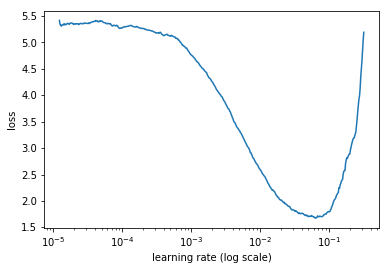

In [31]:
learn.sched.plot()

In [32]:
#1e-2 looks like it will work nicely here.
learn.fit(1e-2, 5) 

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.589472   0.337594   0.89425   
    1      0.437034   0.332991   0.911793                     
    2      0.332033   0.335655   0.901072                     
    3      0.242877   0.368181   0.910331                     
    4      0.222974   0.394129   0.913255                     



[0.39412889, 0.91325536352849146]

In [33]:
#This turns on augmentation
#Also, it is needed to load any save files (further down) that are saved with it FALSE
#Instructor said there's not much point in making save files with it TRUE b/c it trains super fast
learn.precompute=False

In [37]:
learn.lr_find(1e-7)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  4%|▍         | 28/682 [00:08<03:22,  3.22it/s, loss=0.329]

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 78%|███████▊  | 531/682 [02:42<00:46,  3.27it/s, loss=1.03] 


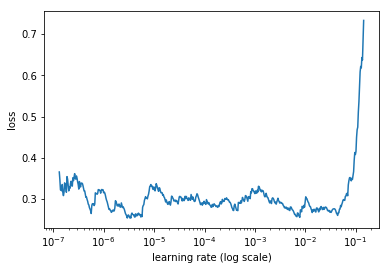

In [38]:
learn.sched.plot()

In [39]:
#this is set for 5 epochs, 1 cycl = 1 epoc
#LR finder gave 1e-2 again

learn.fit(1e-3,5,cycle_len=1)  #5

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.25517    0.250031   0.924951  
    1      0.191587   0.246379   0.928363                    
    2      0.205714   0.242918   0.929825                    
    3      0.218964   0.242936   0.931287                    
    4      0.242753   0.243922   0.931774                    



[0.24392211, 0.93177388216319834]

In [40]:
learn.save('224_pre_3')

In [52]:
learn.precompute=False
learn.load('224_pre_3')

In [41]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 67%|██████▋   | 454/682 [02:19<01:10,  3.26it/s, loss=0.778]

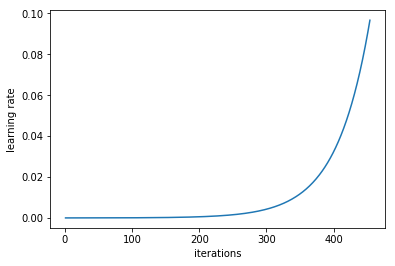

In [42]:
learn.sched.plot_lr()

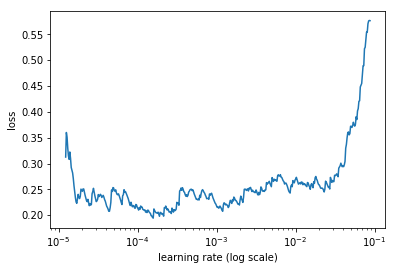

In [43]:
learn.sched.plot()

In [44]:
#LR is not expected to behave this way. It is expected to be high at smaller rates, curve down to a minimum,
#....get noisy and rise again
#See lesson 1 ipymb for example
#In this case, the "high" section is not visible
#Not possible to determine a better rate

In [53]:
#learn.save('224_lastlayer_3')

In [54]:
#learn.precompute=False
#learn.load('224_lastlayer_3')

In [45]:
log_preds,y = learn.TTA(is_test=True)

In [58]:
log_preds.shape

(5, 10357, 120)

In [62]:
np.mean(np.exp(log_preds),axis=0).shape

(10357, 120)

In [64]:
preds = np.mean(np.exp(log_preds),axis=0)  #the mean/axis=0 is needed ONLY if using TTA, if just using .predict, don't use it.
probs_df = pd.DataFrame(preds)

####Column Headers
DogNames = data.classes
ColNums = probs_df.columns.values
col_rename_dict = {i:j for i,j in zip(ColNums,DogNames)}
probs_df.rename(col_rename_dict,axis=1,inplace=True)

###Row Indexes
SUB = pd.read_csv('./data/dogbreeds/submission.csv')
FileNames = SUB.file.apply(lambda x: x[0:-4])
probs_df.set_index(FileNames,inplace=True)
probs_df.index.rename('id',inplace=True)

In [65]:
###In Submission Format
probs_df.to_csv('./data/dogbreeds/Submission3a.csv')

### Local test result: 0.24392 (93.1774%)
### KAGGLE RESULT: 0.24602 (% not returned)

* unfreeze the non-last layers, then run some epochs this way
* base LR Discovered from the super noise find_lr above... it's 1e-2 in the default set up
* I do not have an intuition for whether a lr this small will benefit the accuracy
* And I am still uncertain about the noise in the lr find function

In [56]:
learn.unfreeze()

In [57]:
lr = 7e-5  
#these fractions can be bigger if needed, esp. when dealing with non-imagenet data sets
lr=np.array([lr/18,lr/6,lr/2])

In [58]:
learn.fit(lr,3,cycle_len=1,cycle_mult=2)  #3

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.615545   0.385599   0.893762  
    1      0.538595   0.338607   0.903021                    
    2      0.579779   0.348049   0.903021                    
    3      0.492173   0.322735   0.905945                    
    4      0.421928   0.313696   0.913743                    
    5      0.435209   0.301242   0.91423                     
    6      0.447088   0.328872   0.912768                    



[0.32887208, 0.91276803490711234]

In [59]:
learn.save('224_unfrozenlayers_3')

In [62]:
learn.precompute=False
learn.load('224_unfrozenlayers_3')

In [60]:
learn.lr_find(1e-8)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 424/682 [07:37<04:38,  1.08s/it, loss=1.61] 

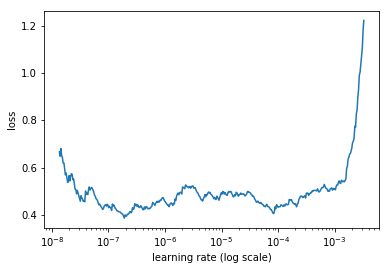

In [61]:
learn.sched.plot()

In [63]:
learn.fit(3e-5,2,cycle_mult=1)  #1e-2

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  1%|          | 6/682 [00:07<14:26,  1.28s/it, loss=0.574]

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.463748   0.309133   0.915692  
    1      0.379743   0.298114   0.914717                    



[0.29811355, 0.91471735322684578]

In [65]:
learn.save('224_mid_3') #save here so I can come back to it if I wish.

In [66]:
learn.lr_find(1e-6)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 49%|████▉     | 333/682 [06:01<06:18,  1.09s/it, loss=1.33] 

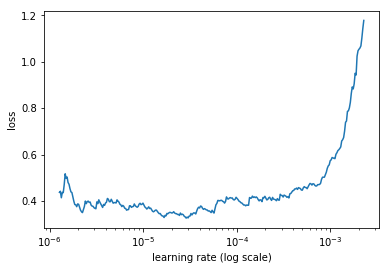

In [67]:
learn.sched.plot()

In [71]:
learn.fit(1e-5,1,cycle_mult=1)  #1e-2

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.344764   0.303109   0.918616  



[0.30310947, 0.91861598812348666]

In [72]:
learn.save('224_mid2_3')

In [73]:
learn.fit(1e-5,1,cycle_mult=1)  #1e-2


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.385133   0.287444   0.920565  



[0.28744367, 0.92056530574608963]

In [74]:
learn.save('224_mid3_3')

In [75]:
learn.load('224_mid2_3')

In [76]:
log_preds,y = learn.TTA(is_test=True)
#TTA means test time augmentation. It makes a whole bunch of augments to help improve accuracy

In [77]:
preds = np.mean(np.exp(log_preds),axis=0)  #the mean/axis=0 is needed ONLY if using TTA, if just using .predict, don't use it.
probs_df = pd.DataFrame(preds)

####Column Headers
DogNames = data.classes
ColNums = probs_df.columns.values
col_rename_dict = {i:j for i,j in zip(ColNums,DogNames)}
probs_df.rename(col_rename_dict,axis=1,inplace=True)

###Row Indexes
SUB = pd.read_csv('./data/dogbreeds/submission.csv')
FileNames = SUB.file.apply(lambda x: x[0:-4])
probs_df.set_index(FileNames,inplace=True)
probs_df.index.rename('id',inplace=True)

###In Submission Format
probs_df.to_csv('./data/dogbreeds/Submission3b.csv')

In [78]:
trn_tfms, val_tfms = tfms_from_model(arch,sz)

def predictSingleImage(fn):
    im = val_tfms(open_image(f'{PATH}'+fn)) # Load Image using fastai open_image in dataset.py
    learn.precompute=False # We’ll pass in a raw image, not activations
    log_preds_single = learn.predict_array(im[None]) # Predict Image
    maxP = np.argmax(log_preds_single,axis=1) # Pick the index with highest log probability
    probs_single = np.exp(log_preds_single) # If you want the probabilities of the classes
    actualclass = data.classes[maxP[0]] # Look up tactualPT   return actualclass
    return actualclass

In [79]:
#Phae is a australian border collie/blue tick heeler mix
predictSingleImage('Dogs/Phaedra.jpg')

'border_collie'

In [80]:
#We're not sure what Rooney is, but he looks a lot like a yorkshire terrier
predictSingleImage('Dogs/Rooney1.jpg')

'yorkshire_terrier'

In [81]:
predictSingleImage('Dogs/Rooney2.jpg')

'yorkshire_terrier'

In [82]:
#Mal is a husky.... last model id'd him correctly.
predictSingleImage('Dogs/Malachi.jpg')

'eskimo_dog'

In [83]:
#presub = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})

In [84]:
#classes = pd.DataFrame(preds_classes)

In [85]:
#submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
#submission.to_csv('data/dogbreeds/submission.csv', index=False)


In [86]:
learn.save('224_end_3')

In [87]:
learn.save('224_end_3')

In [88]:
learn.precompute=False
learn.load('224_end_3')

### KAGGLE RESULT: 0.27121

__INCREASE SIZE and run extra epochs to reduce overfitting:__

In [89]:
learn.set_data(get_data(299,bs)) #<---- cray cray results, NEW INSIGHT!!
learn.freeze()      #few more epoch with 299...  change size, way to get around overfitting!

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [90]:
learn.lr_find(1e-6)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 494/682 [04:24<01:40,  1.87it/s, loss=0.743]

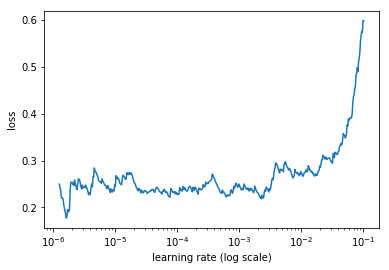

In [91]:
learn.sched.plot()

In [92]:
learn.fit(3e-4,3,cycle_len=1)    

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 6/682 [00:03<06:22,  1.77it/s, loss=0.251]

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.239259   0.26969    0.916179  
    1      0.263454   0.273358   0.916179                    
    2      0.289109   0.269532   0.914717                    



[0.26953211, 0.91471735183258507]

In [93]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 67%|██████▋   | 457/682 [04:04<02:00,  1.87it/s, loss=0.839]

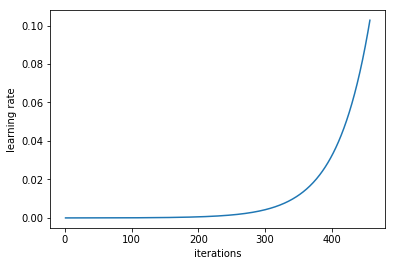

In [94]:
learn.sched.plot_lr()

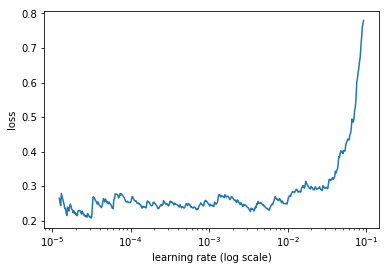

In [95]:
learn.sched.plot()

In [97]:
learn.save('299_pre_3')

In [98]:
learn.fit(1e-5,1,cycle_mult=1)  #1e-2

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 11/682 [00:06<06:26,  1.74it/s, loss=0.179] 


Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.227508   0.273999   0.916179  



[0.27399927, 0.91617933978811339]

In [99]:
learn.save('299_pre2_3')

In [100]:
learn.fit(1e-5,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.287212   0.274352   0.915692  
    1      0.233176   0.271166   0.917154                    
    2      0.250787   0.268268   0.919103                    
    3      0.290948   0.270701   0.915692                    
    4      0.28667    0.271059   0.919103                    
    5      0.235957   0.273715   0.913255                    
    6      0.239011   0.270897   0.919103                    



[0.27089721, 0.91910331639630061]

In [101]:
learn.save('299_pre3_3')

In [ ]:
learn.load('299_pre3_3')

In [102]:
log_preds,y = learn.TTA(is_test=True)
#log_preds = learn.predict(is_test=True)

In [103]:
preds = np.mean(np.exp(log_preds),axis=0)  #the mean/axis=0 is needed ONLY if using TTA, if just using .predict, don't use it.
probs_df = pd.DataFrame(preds)

FileNames = SUB.file.apply(lambda x: x[0:-4])
probs_df.set_index(FileNames,inplace=True)
####Column Headers
DogNames = data.classes
ColNums = probs_df.columns.values
col_rename_dict = {i:j for i,j in zip(ColNums,DogNames)}
probs_df.rename(col_rename_dict,axis=1,inplace=True)

###Row Indexes
SUB = pd.read_csv('./data/dogbreeds/submission.csv')
probs_df.index.rename('id',inplace=True)

###In Submission Format
probs_df.to_csv('./data/dogbreeds/Submission3c.csv')

### KAGGLE RESULT: 0.25343

Slight improvement, but my submission 3a was better, with 0.24602

https://www.kaggle.com/hamil168